In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy
from scipy.fft import fft, rfft, fftshift,rfft2
from scipy.special import jv
from matplotlib.image import NonUniformImage
import sncosmo
import pandas
import h5py
from astropy.io import fits
import astropy.units as units
from astropy.cosmology import Planck18 as cosmo


In [2]:
intensity = pandas.read_hdf('SN2011fe_MLE_intensity_maxlight.hdf', key='intensity')
lambdas = intensity.index.values
I_nu_p = intensity.values
p_rays = intensity.columns.values

# flip the order of wavelengths
lambdas = numpy.flip(lambdas)
I_nu_p = numpy.flip(I_nu_p,axis=0)
I_lam_p = I_nu_p/lambdas[:,None]/lambdas[:,None]
flux_int = numpy.trapz(I_lam_p*p_rays, x=p_rays, axis=1)

In [3]:
# integrated spectrum normalized to 12 mag
spectrum = sncosmo.Spectrum(lambdas, flux_int)
spectrum_mag = spectrum.bandmag('bessellb', magsys='vega')
flux_int = flux_int * 10**((spectrum_mag-12)/2.5) # now in units of  (erg / s / cm^2 / A) for B=12 mag
# want  dΓ/dν = AFv/(hν0).
# 
# spectrum = sncosmo.Spectrum(lambdas, flux_int) # now in units of  (erg / s / cm^2 / A) for B=12 mag
Area = 88 * 100 * 100. # cm^2
Area = numpy.pi*(9.96/2)**2*1e4
print(Area)
eff = 0.73*.9*.6
print(eff)
Area=Area*eff
h = 6.626* 10**(-34+7)  # erg s
c = 3e10 # cm/s
lcm = lambdas/1e8  # cm
dGammadnu = Area * flux_int * lambdas  / h /c/c*lcm*lcm
# plt.plot(lambdas,dGammadnu)

sigma_t =13*10**-12

norm = I_nu_p.copy()
norm = norm/norm[:,1][:,None]
maxs = numpy.max(norm,axis=1)
maxorder = numpy.argsort(maxs)

idx8750 = numpy.abs(lambdas - 8750).argmin()
idx3700 = numpy.abs(lambdas - 3700).argmin()
idx6100 = numpy.abs(lambdas - 6100).argmin()
idx6149 = numpy.abs(lambdas - 6149).argmin()
idx6177 = numpy.abs(lambdas - 6177).argmin()
idx6355 = numpy.abs(lambdas - 6355).argmin()
idx4700 = numpy.abs(lambdas - 4700).argmin()
idx6055 = numpy.abs(lambdas - 6055).argmin()

779127.5444608831
0.3942


In [4]:
def dft_polar(y, norder=None):
    ny = len(y)
    if norder is None:
        norder = ny
    rhos = numpy.arange(norder)/ny
    ans = numpy.zeros(norder)
    theta = numpy.arange(ny)
    for i, rho in enumerate(rhos):
        integrand = y*jv(0,2*numpy.pi*rho*theta)*theta
        # ans[i]=numpy.trapezoid(integrand)
        ans[i]=numpy.trapz(integrand)
    return 2*numpy.pi*ans

def dft_polar_der(y, norder=None):
    ny = len(y)
    if norder is None:
        norder = ny
    rhos = numpy.arange(norder)/ny
    ans = numpy.zeros(norder)
    theta = numpy.arange(ny)
    for i, rho in enumerate(rhos):
        integrand = y*jv(1,2*numpy.pi*rho*theta)*theta**2
        # ans[i]=numpy.trapezoid(integrand)
        ans[i]=numpy.trapz(integrand)
    return -(2*numpy.pi)**2*ans

# for s=1
def dgamma2ds(y,norder=None):
    ny = len(y)
    if norder is None:
        norder = ny
    rhos = numpy.arange(norder)/ny
    gamma = dft_polar(y, norder=norder)
    return - 2* gamma * rhos *dft_polar_der(y, norder=norder)

def dgamma2dsi(y, u, vs, norder=None):
    ny = len(y)
    if norder is None:
        norder = ny
    rhos = numpy.arange(norder)/ny
    gamma = dft_polar(y, norder=norder)
    dgammadrho = dft_polar_der(y, norder=norder)
    dum = numpy.sqrt(u**2  + vs**2)
    return 2* numpy.interp(dum, rhos, gamma) * u/dum * numpy.interp(dum, rhos, dgammadrho)

In [5]:
# norder = 200
# ncirc = 100
# factor =20
# flux = numpy.zeros(ncirc*factor)
# flux[:ncirc]=1
# gamma = dft_polar(flux,norder=norder)
# gamma20=gamma[0]**2
# gamma=gamma/gamma[0]
# gamma2 = gamma*gamma
# x = numpy.arange(0,10,0.1)
# # plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/10,gamma,label=r'$\gamma$')
# # plt.plot(x,(2*jv(1,x)/x),label='sqrt Airy')
# # plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/10,20*dft_polar_der(flux, norder=norder)/gamma20,label=r'$d\gamma/d\rho$')
# # plt.plot((0,12),(0,0))

# # plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/10,gamma2,label=r'$\gamma^2$')
# plt.plot(x,(2*jv(1,x)/x)**2,label='Airy')
# plt.plot(x,2*(2*jv(1,x)/x)*(jv(0,x)-jv(2,x)-2*jv(1,x)/x),label='dAirydtheta')
# plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/factor,dgamma2ds(flux, norder=norder)/gamma20,label=r'$d\gamma^2/d\rho$')
# # plt.plot((0,12),(0,0))
# # plt.ylim((0,10))

# # plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/10,numpy.abs(dgamma2ds(flux,norder=norder))/gamma20)

# plt.legend()
# plt.xlim((0,10))

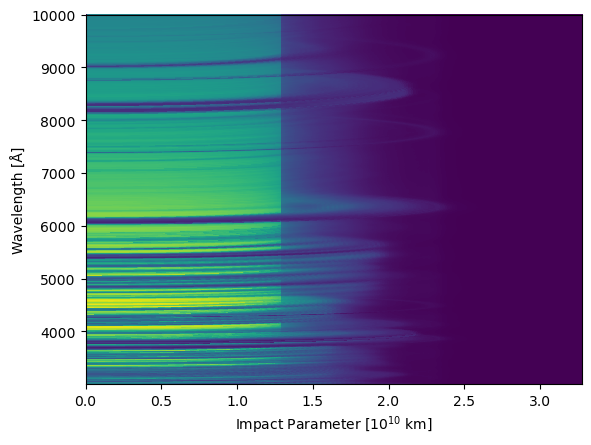

In [6]:
interp = 'nearest'
fig, ax = plt.subplots()
im = NonUniformImage(ax, interpolation=interp, extent=(p_rays[0]/1e15,p_rays[-1]/1e15,lambdas[0],lambdas[-1]))
im.set_data(p_rays/1e15, lambdas, I_nu_p)
ax.add_image(im)
ax.set_xlim(p_rays[0]/1e15, p_rays[-1]/1e15)
ax.set_ylim(lambdas[0],lambdas[-1])
ax.set_ylabel(r"Wavelength [Å]")
ax.set_xlabel(r"Impact Parameter [$10^{10}~\text{km}$]")
plt.savefig("sn2001fe.pdf")

In [7]:
ren = I_lam_p.copy()
ren = ren/ren.sum(axis=1)[:,None]
# plt.imshow(ren, extent=(p_rays[0]/1e15,p_rays[-1]/1e15,lambdas[0],lambdas[-1]),aspect='auto',norm='log')

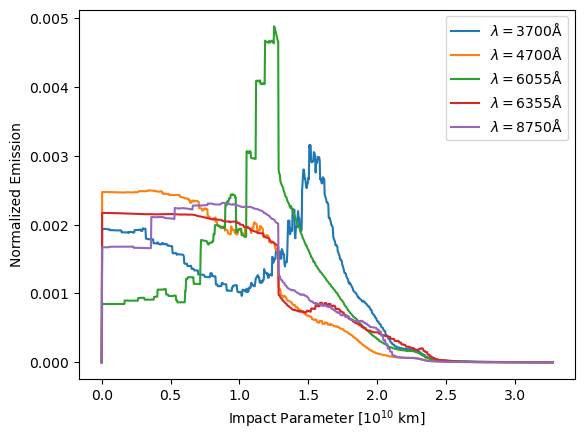

In [8]:
idxs = [idx3700, idx4700, idx6055, idx6355,idx8750]
for idx in idxs:
    plt.plot(p_rays/1e15, ren[idx,:],label=r"$\lambda={:.0f}$Å".format(lambdas[idx]))
    
plt.xlabel(r"Impact Parameter [$10^{10}~\text{km}$]")
plt.ylabel(r"Normalized Emission")
plt.legend()
plt.savefig('impact.pdf')

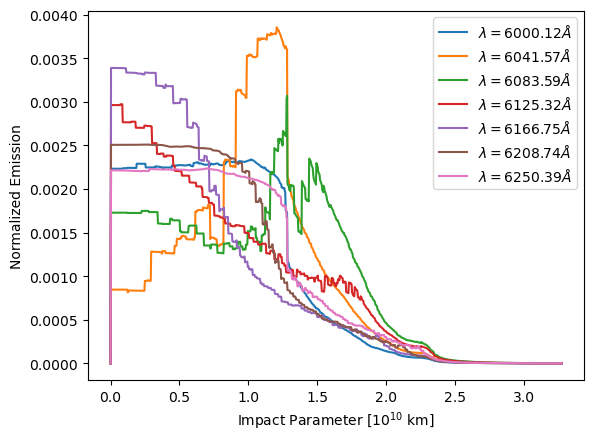

In [9]:
lams = numpy.linspace(6000,6250,7)
# lams = [6000,6030,6060,6100,6130,6170,6250]
idxs = [numpy.abs(lambdas - l).argmin() for l in lams]
for idx in idxs:
    plt.plot(p_rays/1e15, ren[idx,:],label=r"$\lambda={:.2f}\AA$".format(lambdas[idx]))

plt.xlabel(r"Impact Parameter [$10^{10}~\text{km}$]")
plt.ylabel(r"Normalized Emission")
plt.legend()

/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_24094/369716945.py:41: RuntimeWarning: invalid value encountered in divide
  airy = (2*jv(1,zeta)/zeta)**2
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_24094/369716945.py:48: RuntimeWarning: invalid value encountered in divide
  dairy = ((2*jv(1,zeta)/zeta)*(jv(0,zeta)-jv(2,zeta)-2*jv(1,zeta)/zeta))


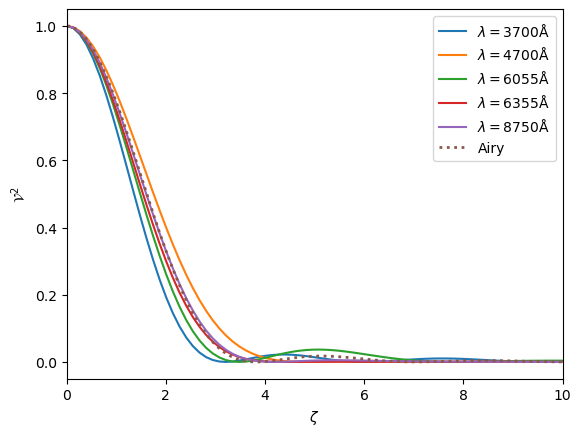

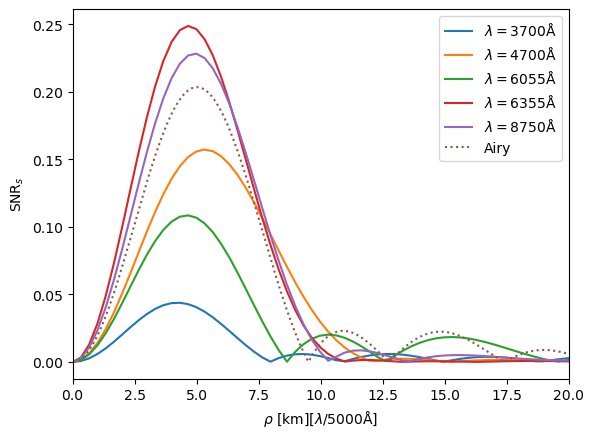

In [11]:
def gamma2snr(siII=False):
    # nd = axis0[:].shape[0]
    nd = p_rays.shape[0]
    delta = p_rays[1]-p_rays[0]
    drad = 0.475e15
    drad = 0.875e15
    ndisk = int(2*drad/delta)
    factor=25
    norder = factor * 5

    Dwidth = (p_rays[-1]-p_rays[0]) * factor * units.cm
    DA = cosmo.angular_diameter_distance(0.004)
    Deltau = (DA/Dwidth).decompose()*5000e-10/1000   #at 5000A in km

    # nexpand = int(factor*ndisk)
    flux = numpy.zeros(nd*factor)
    fig, ax = plt.subplots()
    fig2, ax2 = plt.subplots()  
    # for index in [maxorder[0],idx3700,maxorder[-1],idx6355,idx8750]:
    idxs = [idx3700, idx4700, idx6055, idx6355,idx8750]
    if siII:
        lams = numpy.linspace(6000,6250,7)
        idxs = [numpy.abs(lambdas - l).argmin() for l in lams]
        
    # for index in [maxorder[0],maxorder[-1],idx6100, idx6177, idx8750]:
    for index in idxs:
        flux[:]=0
        flux[:nd] = I_lam_p[index,:] #block0_values[index,:]
        # flux[:ndisk] = 1
        gamma = dft_polar(flux,norder=norder)
        gamma0 = gamma[0]
        gamma=gamma/gamma[0]
        gamma2 = gamma*gamma
        ax.plot(numpy.arange(gamma2.shape[0])*2*numpy.pi/(nd*factor/ndisk),gamma2,label=r"$\lambda={:.0f}$Å".format(lambdas[index]))
    
        fm = dgamma2ds(flux, norder=norder)/gamma0**2
        fm= numpy.abs(fm) * dGammadnu[index] * (128*numpy.pi)**(-0.25) * numpy.sqrt(3600/sigma_t)
        ax2.plot(numpy.arange(fm.shape[0])*Deltau,fm,label=r"$\lambda={:.0f}$Å".format(lambdas[index]))

    zeta = numpy.arange(0,nd*10,0.01)
    airy = (2*jv(1,zeta)/zeta)**2
    ax.plot(zeta,airy,label='Airy',ls='dotted',lw=2)
    ax.set_ylabel(r"$\mathcal{V}^2$")
    ax.set_xlabel(r"$\zeta$")
    ax.set_xlim((0,10))
    ax.legend()
    fig.savefig('gamma2.pdf')
    dairy = ((2*jv(1,zeta)/zeta)*(jv(0,zeta)-jv(2,zeta)-2*jv(1,zeta)/zeta))
    ax2.plot(zeta*Deltau / (2*numpy.pi/(nd*factor/ndisk)),0.5*numpy.abs(dairy),label='Airy',ls='dotted')
    ax2.set_ylabel(r"$\text{SNR}_s$")
    ax2.set_xlabel(r"$\rho$ [km][$\lambda/5000$Å]")
    ax2.set_xlim((0,20))
    # ax2.set_ylim((0,1))
    ax2.legend()
    fig2.savefig('snr.pdf')

gamma2snr(siII=False)

/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_15940/1415450247.py:36: RuntimeWarning: invalid value encountered in divide
  ax.plot(numpy.arange(_.shape[0])*2*numpy.pi/(nd*factor/ndisk),D/_,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))


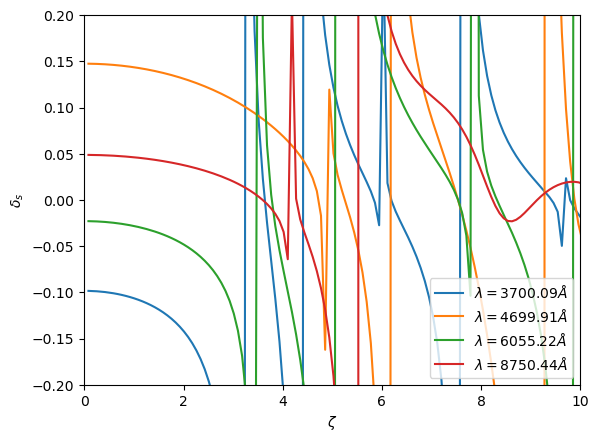

In [25]:
def bias():
    nd = p_rays.shape[0]
    delta = p_rays[1]-p_rays[0]
    drad = 0.475e15
    drad = 0.875e15

    ndisk = int(2*drad/delta)
    factor=40
    norder = factor * 5
    
    # nexpand = int(factor*ndisk)
    flux = numpy.zeros(nd*factor)
    fig, ax = plt.subplots()
    index = idx6355 #idx6100 #maxorder[0]
    flux[:]=0
    flux[:nd] = I_lam_p[index,:]
    gamma = dft_polar(flux,norder=norder)
    gamma0 = gamma[0]
    gamma = gamma/gamma0
    gamma2fid = gamma*gamma
    
    # for index in [maxorder[0],idx3700,maxorder[-1],idx6355,idx8750]:
    # for index in [maxorder[0],idx3700,maxorder[-1],idx8750]:
    # idxs = [idx3700, idx4700, idx6149, idx6355,idx8750
    idxs = [idx3700, idx4700, idx6055, idx8750]

    for index in idxs:
        flux[:]=0
        flux[:nd] = I_lam_p[index,:]
        gamma = dft_polar(flux,norder=norder)
        gamma0 = gamma[0]
        gamma = gamma/gamma0
        gamma2 = gamma * gamma
        _ = dgamma2ds(flux, norder=norder)/gamma0**2
        D = gamma2-gamma2fid
        ax.plot(numpy.arange(_.shape[0])*2*numpy.pi/(nd*factor/ndisk),D/_,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))
    
    ax.set_ylabel(r"$\delta_s$")
    ax.set_xlabel(r"$\zeta$")
    ax.set_xlim((0,10))
    ax.set_ylim((-0.2,0.2))
    ax.legend()
    fig.savefig('bias.pdf')

bias()

In [ ]:
def gamma2snr2():
    nd = axis0[:].shape[0]
    delta = axis0[1]-axis0[0]
    drad = 0.475e15
    ndisk = int(2*drad/delta)
    factor=20
    norder = factor * 5
    
    # nexpand = int(factor*ndisk)
    flux = numpy.zeros(nd*factor)
    fig, ax = plt.subplots()
    fig2, ax2 = plt.subplots()  
    for index in [maxorder[0],maxorder[-1],idx6177 ,idx6355,idx8750]:
        flux[:]=0
        flux[:nd] = block0_values[index,:]
        # flux[:ndisk] = 1
        gamma = dft_polar(flux,norder=norder)
        gamma0 = gamma[0]
        gamma=gamma/gamma[0]
        gamma2 = gamma*gamma
        # ax.plot(numpy.arange(gamma2.shape[0])*2*numpy.pi/(nd*factor/ndisk),gamma2,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))

        fm = dgamma2dsi(flux, 1, numpy.arange(20), norder=norder)/gamma0**2
        # fm = dgamma2ds(flux, norder=norder)/gamma0**2
        # fm = numpy.zeros((2,2))
        # dg2ds1 = dgamma2ds1(flux, norder=norder)/gamma0**2
        # fm[0][0] = dgamma2ds(flux, norder=norder)/gamma0**2
        # fm= numpy.abs(fm)
        ax2.plot(numpy.arange(fm.shape[0])*2*numpy.pi/(nd*factor/ndisk),fm,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))
    
    # zeta = numpy.arange(0,nd,0.01)

    # dairy = (2*(2*jv(1,zeta)/zeta)*(jv(0,zeta)-jv(2,zeta)-2*jv(1,zeta)/zeta))
    # ax2.plot(zeta,numpy.abs(dairy),label='Airy',ls='dotted')
    # ax2.set_ylabel(r"$\text{SNR}_s$")
    # ax2.set_xlabel(r"$\zeta$")
    # ax2.set_xlim((0,10))
    # ax2.set_ylim((0,1))
    ax2.legend()
    fig2.savefig('snr2.pdf')

gamma2snr2()